In [152]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

In [2]:
#!pip3 install --upgrade multiple-hypothesis-testing

## Findings: (4/8/2022):
 - With $T=100$ and non stable HC, we get ~ 10 new discoveries with HC for genes in the range 100-200
 - About 3 of which relies on 2 P-values (the rest on one) (sparsity, 0.01 - 0.02)
 - To do: 1) try the entire range 2) try larger Ts

## Duscussion:
 - Simulate null of HC and log-rank: shuffle responses vector of each gene. 
 - Biological intepertation
 - Try merging time stamps


## Data:
- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

In [346]:
from survival import ( hypergeom_test, q95)


def log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))
    
    Nt = Nt2 + Nt1
    e0 = Nt2 * (Ot1 + Ot2) / Nt
    var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))

    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2 * norm.cdf(-np.abs(z))

    return z, pval


In [340]:
def multi_pvals(Nt1, Nt2, Ot1, Ot2, test='hypergeom',
                randomize=False, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))

    Nt = Nt2 + Nt1

    if test == 'binomial':
        n = Ot1 + Ot2
        p = Nt2 / Nt
        x = Ot2
        pvals = binom_test(x, n, p, randomize=randomize, alt=alternative)
    elif test == 'hypergeom':
        pvals = hypergeom_test(Ot2, Nt, Nt2, Ot1 + Ot2,
                               randomize=randomize, alternative=alternative)

    return pvals


In [341]:

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.4, randomize=False):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    FDR
    """
    
    lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2)
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals < 1], stbl=stbl) # if not using stbl=False, then sometimes
                                      # HC misses the significance of the strongest effect 
    
    return {'Logrank': np.abs(lr),
            'HC': mt.hc(gamma=gamma)[0],
            'Fisher': mt.fisher(),
            'minP': mt.minp(),
            'BJ': mt.berk_jones(gamma=.45),
            #'FDR': mt.fdr()[0],
            #'wilcoxon': -np.log(1e-20 + scipy.stats.ranksums(Nt1, Nt2).pvalue),
           }

## Load Data:

In [342]:
#df = pd.read_csv("./Data/Gene_expression_data/AML_Bull.csv")
df = pd.read_csv("./Data/data.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

In [343]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg#.groupby('time').sum()
    dft = dft.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft[1:]['at-risk'] - dft[:-1]['cum_dead'] - dft[:-1]['cum_censored']
    
    dft = dft.groupby('time').max()
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name,'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    # Todo: merge time indices
    dfm = df1[['at-risk', 'dead']].join(df2[['at-risk', 'dead']], lsuffix='1', rsuffix='2', how='outer')\
                     .fillna(method='ffill')\
                     .fillna(method='bfill') 
    return dfm

In [381]:
EPS = 1e-20

def evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, **kwargs):
    """
    Evaluate many tests for comparing the lists Nt1 and Nt2

    Args:
    :Nt1: first list of at-risk subjects
    :Nt2: second list of at-risk subjects
    :Ot1: number of events in group 1
    :Ot2: number of events in group 2


    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """

    randomize = kwargs.get('randomize', False)
    alternative = kwargs.get('alternative', 'both')  # 'both' != 'two-sided'
    stbl = kwargs.get('stbl', True)

    test_results = {}

    #test_results['log_rank_lifeline'] = -np.log(lrln_pval + EPS)

    if alternative == 'both' or alternative == 'greater':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='greater')
        test_results['log_rank_greater'] = np.abs(lr)  # large values are significant

        pvals_greater = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='greater',
                                    randomize=randomize)
        mt = MultiTest(pvals_greater[pvals_greater<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc_greater'] = mt.hc()[0]
        test_results['fisher_greater'] = mt.fisher()
        test_results['min_p_greater'] = mt.minp()
        test_results['berk_jones_greater'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_greater'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='greater').pvalue + EPS)

    if alternative == 'both' or alternative == 'less':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='less')
        test_results['log_rank_less'] = np.abs(lr)  # large values are significant

        pvals_less = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='less',
                                    randomize=randomize)
        mt = MultiTest(pvals_less[pvals_less<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc_less'] = mt.hc()[0]
        test_results['fisher_less'] = mt.fisher()
        test_results['min_p_less'] = mt.minp()
        test_results['berk_jones_less'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon_less'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='less').pvalue + EPS)

    if alternative == 'two-sided':
        lr, lr_pval = log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided')
        test_results['log_rank'] = np.abs(lr)

        pvals_2sided = mutli_pvals(Nt1, Nt2, Ot1, Ot2, alternative='two-sided',
                                    randomize=randomize)
        mt = MultiTest(pvals_2sided[pvals_2sided<1], stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        test_results['hc'] = mt.hc()[0]
        test_results['fisher'] = mt.fisher()
        test_results['min_p'] = mt.minp()
        test_results['berk_jones'] = mt.berk_jones(gamma=.45)
        test_results['wilcoxon'] = -np.log(scipy.stats.ranksums(
            Nt1, Nt2, alternative='two-sided').pvalue + EPS)

    return test_results


In [382]:
def reduce_time_resolution(df, T):
    """
    Group together events in surivial data
    across uniform time intervals. 
    
    Args:
    :df: original dataset. Index represent time of events
    :T:  maximal number of time intervals
    
    """
    
    Tmin = df.index.min()
    Tmax = df.index.max()
    tt = np.linspace(Tmin, Tmax, T)
    dfc = pd.DataFrame()
    for t_down, t_up in zip(tt[:-1], tt[1:]):
        dft = df[(t_down <= df.index) & (df.index < t_up)]
        r = dft.sum()[['dead1', 'dead2']]
        r['at-risk1'] = dft['at-risk1'].max()
        r['at-risk2'] = dft['at-risk2'].max()
        dfc = dfc.append(r, ignore_index=True)
    return dfc.fillna(method='backfill').dropna()

In [514]:
np.seterr(all='warn')

T = 100
res = pd.DataFrame()
stbl = False

def test_gene(data, gene_name, T, stbl=False):
    """
    Evaluate all test statistics for comparing the survival curves
    for the two groups involving the response of :gene_name: 
    Also, consolidate event times based on :T:. 
    
    Args:
    :data: is the entire dataset containing the group division 
            at minimum, :data: should contain the columns  
            :gene_name:, `events`, `time`
    :gene_name:  the name of the column to test
    :T:    is the new maximal time interval. If T == -1 then we 
            use the original times
    
    """
    if T > 0:
        dfr = reduce_time_resolution(two_groups_gene(data, gene_name), T)
    else:
        dfr = two_groups_gene(df, gene_name)
    r = evaluate_test_stats(dfr['at-risk1'].values, dfr['at-risk2'].values,
                            dfr['dead1'].values, dfr['dead2'].values,
                            stbl=stbl, randomize=False
                           )
    rrev = evaluate_test_stats(dfr['at-risk2'].values, dfr['at-risk1'].values,
                               dfr['dead2'].values, dfr['dead1'].values,
                              stbl=stbl, randomize=False)

    r['name'] = gene_name 
    rrev['name'] = gene_name

    rdf = pd.DataFrame(r, index=[0])
    revdf = pd.DataFrame(rrev, index=[0])
    
    return rdf.join(revdf, rsuffix='_rev')

In [ ]:
# here we go over all genes:

res = pd.DataFrame()
for gene_name in tqdm(gene_names[:2]):
   # try:
    r = test_gene(df, gene_name, T)
    res = res.append(r, ignore_index=True)
   # except:
        #print(f"Error in evaluating {gene_name}")
res

In [512]:
def simulate_null(T, N1, N2, lam0, nMonte, stbl=True):
    """
    Args:
    -----
    :N1:      Initial size of group 1
    :N2:      Initial size of group 2
    :T:       Total numebr of events
    :nMonte:  number of experiments to evaluate

    """
    
    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0 * np.ones(T), 0, 0)
        Ot1 = -np.diff(Nt1)
        Ot2 = -np.diff(Nt2)
        res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, stbl=True)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


def std_95(x):
    return np.std(x) / np.sqrt(len(x)) * np.sqrt(.95 * (1 - .95) )

def simulate_null_data(data, T, rep = 1, stbl=True):
    """
    Generate random group assignments. 
    Evaluate test statistics. 

    """
    
    df0 = pd.DataFrame()
    gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]
    
    print("Simulating null using data...")
    
    for _ in range(rep):
        print("Sampling a random division...")
        df_copy = df.copy()
        df_copy.iloc[:, 1:-2] = np.random.randint(2, size = df.iloc[:, 1:-2].shape)    
        print(f"Testing {len(gene_names)} 'null' genes...")
        for gene_name in tqdm(gene_names): 
            res = test_gene(df_copy, gene_name, T, stbl=stbl)
            df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


In [622]:
df0_data = simulate_null_data(df, T, rep=1, stbl=True)
df0_data.to_csv('null_data_stbl.csv')
df0_data.agg([q95])

Simulating null using data...
Sampling a random division...


  0%|          | 0/9259 [00:00<?, ?it/s]

Testing 9259 'null' genes...


100%|██████████| 9259/9259 [35:13<00:00,  4.38it/s]


,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,1.790985,0.720442,1.527604,5.309598,25.50439,3.505153,1.790985,4.975899,27.763616,46.051702,...,5.378988,25.279923,3.494196,1.790985,4.975899,27.767019,46.051702,46.051702,3.505153,NaN


In [558]:
df0_data.agg([q95])

,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,1.793112,1.175282,1.533571,5.273233,25.519162,3.479898,1.793112,197.06843,27.759652,46.051702,...,5.317619,25.538305,3.449179,1.793112,197.06843,27.788715,46.051702,46.051702,3.479898,NaN


In [ ]:
T = 100
res = pd.DataFrame()
stbl = True

for gene_name in tqdm(gene_names):
   # try:
    dfr = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    r = evaluate_test_stats(dfr['at-risk1'].values, dfr['at-risk2'].values,
                            dfr['dead1'].values, dfr['dead2'].values,
                            stbl=stbl, randomize=False
                           )
    rrev = evaluate_test_stats(dfr['at-risk2'].values, dfr['at-risk1'].values,
                               dfr['dead2'].values, dfr['dead1'].values,
                              stbl=stbl, randomize=False)

    r['name'] = gene_name 
    rrev['name'] = gene_name

    rdf = pd.DataFrame(r, index=[0])
    revdf = pd.DataFrame(rrev, index=[0])
    
    res = res.append(rdf.join(revdf, rsuffix='_rev'), ignore_index=True)


In [389]:
lam0 = .5*(np.log(dfr['at-risk1'].max() / dfr['at-risk1'].min()) / T) + .5*(np.log(dfr['at-risk2'].max() / dfr['at-risk2'].min()) / T)
res0 = simulate_null(T, 1500, 1500, lam0, 1000)
res0

  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

Simulating null...


 63%|██████▎   | 630/1000 [00:06<00:03, 98.60it/s]<ipython-input-346-4025eac20da7>:30: RuntimeWarning: invalid value encountered in true_divide
  e0 = Nt2 * (Ot1 + Ot2) / Nt
<ipython-input-346-4025eac20da7>:31: RuntimeWarning: invalid value encountered in true_divide
  var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))
100%|██████████| 1000/1000 [00:10<00:00, 97.87it/s]


,berk_jones_greater,berk_jones_less,fisher_greater,fisher_less,hc_greater,hc_less,log_rank_greater,log_rank_less,min_p_greater,min_p_less,wilcoxon_greater,wilcoxon_less
q95,13.260447,46.051702,1.923987,20.215973,1.17156,4.969994,1.991719,1.991719,6.571421,46.051702,1.66171,1.686086


In [455]:
df0_data

,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,1.785793,1.195944,1.528463,5.343371,25.353016,3.4743,1.785793,197.06843,27.760701,46.051702,...,5.347778,25.523275,3.477099,1.785793,197.06843,27.776471,46.051702,46.051702,3.4743,NaN


In [390]:
res0

,berk_jones_greater,berk_jones_less,fisher_greater,fisher_less,hc_greater,hc_less,log_rank_greater,log_rank_less,min_p_greater,min_p_less,wilcoxon_greater,wilcoxon_less
q95,13.260447,46.051702,1.923987,20.215973,1.17156,4.969994,1.991719,1.991719,6.571421,46.051702,1.66171,1.686086


In [408]:
# filter results
LRt = 2
HCt = 2
HCp = 2
minPt = 12.45

resi = res[((res.hc_greater > HCt) & (res.log_rank_greater < LRt) & 
           (res.hc_greater_rev < HCp) & (res.log_rank_greater_rev < LRt) )
           | 
           ((res.hc_greater < HCp) & (res.log_rank_greater < LRt) & 
           (res.hc_greater_rev > HCt) & (res.log_rank_greater_rev < LRt) )
          ]
resi

,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
21,1.919462,2.293929,1.050655,6.238339,28.920787,0.372212,1.919462,197.06843,27.146602,46.051702,...,5.064576,11.424172,1.168633,1.919462,197.06843,20.147838,46.051702,46.051702,0.372212,ABCB6
25,0.055231,-0.060738,1.423377,4.243774,12.457193,0.764838,0.055231,197.06843,25.827873,46.051702,...,6.084959,17.080289,0.626254,0.055231,197.06843,24.995215,46.051702,46.051702,0.764838,ABCC1
34,1.819542,-0.842228,1.156294,2.986994,22.271082,0.583081,1.819542,197.06843,25.384685,46.051702,...,6.295831,11.721475,0.816843,1.819542,197.06843,22.173415,46.051702,46.051702,0.583081,ABCD1
83,1.804874,-0.476371,1.047249,3.850467,21.197620,0.119167,1.804874,197.06843,24.542441,46.051702,...,5.765069,8.060324,2.186223,1.804874,197.06843,22.976696,46.051702,46.051702,0.119167,ACOT13
113,0.945041,-0.146242,1.318205,4.131730,16.669946,0.502313,0.945041,197.06843,27.634827,46.051702,...,6.290391,10.552800,0.929198,0.945041,197.06843,24.802879,46.051702,46.051702,0.502313,ACTL8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9204,0.400011,-0.568935,1.231348,3.762355,14.749756,0.264183,0.400011,197.06843,24.135771,46.051702,...,6.119240,14.060808,1.460300,0.400011,197.06843,24.057441,46.051702,46.051702,0.264183,ZNF562
9206,0.581032,0.732616,1.323099,5.058765,13.823927,0.363391,0.581032,197.06843,22.250776,46.051702,...,6.433051,20.208186,1.188474,0.581032,197.06843,22.544346,46.051702,46.051702,0.363391,ZNF573
9224,1.141858,3.489586,1.320277,6.908436,16.800281,0.929198,1.141858,197.06843,30.526684,46.051702,...,4.666902,12.972569,0.502313,1.141858,177.37174,18.607572,46.051702,46.051702,0.929198,ZNF692
9227,1.457085,2.337065,1.457619,6.333798,17.087577,0.660066,1.457085,197.06843,22.186464,46.051702,...,1.480045,19.888205,0.727361,1.457085,197.06843,22.604513,46.051702,46.051702,0.660066,ZNF711


In [478]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"

In [563]:
def empirical_pval(x, stat_name, df0):
    return np.mean(df0[stat_name].values >= x)

In [624]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=False, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curves(df, gene_name, T):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

        
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        print("reversing...")
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        
        Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
        Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
        stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2,
                                    stbl=stbl, randomize=False)
    
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    
    dfg['pvalue'] = pvals
    dfg['Group 1'] = dfg['at-risk1'] / dfg['at-risk1'].max()
    dfg['Group 2'] = dfg['at-risk2'] / dfg['at-risk2'].max()
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
    
    plt.step(dfg.index, dfg['Group 1'], 'b')
    plt.step(dfg.index, dfg['Group 2'], 'r')
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0_data)
    hc_pval_rev = empirical_pval(stats['hc_greater_rev'], 'hc_greater_rev', df0_data)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0_data)
    plt.title(f"{gene_name}, (HC={np.round(hc_pval,2)},  Log-rank={np.round(logrank_pval,2)})")
    plt.ylabel('proportion')
    #plt.savefig(f"Figs/{gene_name}.png")
    #plt.xlim(1000, 1500)
    plt.show()
    
    spv = np.sort(pvals)
    n = len(pvals)
    uu = np.linspace(1/n, 1, n)
    plt.plot(uu, uu, alpha=.3, color='k')
    plt.step(uu, spv, 'b')
    plt.step(uu[spv < hct], spv[spv < hct], 'r')
    plt.title("sorted P-values")
    plt.show()
    
    plt.plot(mt._zz)
    plt.title("z scores of P-values")
    plt.show()

def illustrate_survival_curve(df, gene_name, T):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        print("reversing...")
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        
        Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
        Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
        stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2,
                                    stbl=stbl, randomize=False)
    
    print("HC (evaluate_test_stats) = ", stats['hc_greater'])
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    
    dfg['pvalue'] = pvals
    dfg['Survival Proprotion X'] = dfg['at-risk1'] / dfg['at-risk1'].max()
    dfg['Survival Proprotion Y'] = dfg['at-risk2'] / dfg['at-risk2'].max()
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
    plt.step(dfg.index, dfg['Survival Proprotion X'], 'b')
    plt.step(dfg.index, dfg['Survival Proprotion Y'], 'r')
    print(dfg[fpval].rename(columns={'at-risk1' : 'at-risk X', 'at-risk2' : 'at-risk Y',
                                     'dead1' : 'events X', 'dead2' : 'events Y'
                                    }))
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0_data)
    hc_pval_rev = empirical_pval(stats['hc_greater_rev'], 'hc_greater_rev', df0_data)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0_data)
#    print(hc_pval)
    st_HC = r"$\hat{p}(\mathrm{HC})$"
    st_HC_rev = r"$\hat{p}(\tilde{\mathrm{HC}})$"
    st_LR = r"$\hat{p}(\mathrm{LR})$"
    plt.title(rf"{gene_name}: {st_HC}={np.round(hc_pval,2)}, {st_HC_rev}={np.round(hc_pval_rev,2)}, {st_LR}={np.round(logrank_pval,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    

HC (evaluate_test_stats) =  2.2939294834199297
HC =  2.2939294834199297
    at-risk X  at-risk Y  events X  events Y    pvalue  Survival Proprotion X  \
44     1259.0     1263.0       0.0       9.0  0.001953                0.82073   

    Survival Proprotion Y  
44               0.822801  


KeyError: 'hc_greater_rev'

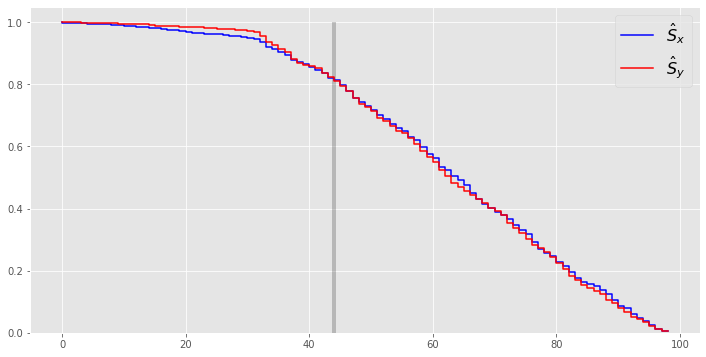

In [625]:
plt.rcParams['figure.figsize'] =  [12, 6]

for r in resi.head(5).iterrows():
    gene_name = r[1]['name']
    illustrate_survival_curve(df, gene_name, T)
    plt.show()
    
# HERE!! 
Also report hc_rev pvalue!

In [414]:
for r in resi.iterrows():
    gene_name = r[1]['name']
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

        
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    
    if stats['hc_greater'] < HCt: # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1'})
        
        Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
        Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
        stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2,
                                    stbl=stbl, randomize=False)
    
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    hc, hct = mt.hc(gamma=.5)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
    if fpval.sum() > 5:
        print(gene_name)

E2F6
ERCC8
PSMG2
RPL22
SLC27A2


In [601]:
remote_dir

'/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/'

In [604]:
!pwd

/Users/kipnisal/survival


HC (evaluate_test_stats) =  2.1451003702339717
HC =  2.1451003702339717
    at-risk X  at-risk Y  events X  events Y    pvalue  Survival Proprotion X  \
36     1399.0     1389.0       0.0       5.0  0.030583               0.911995   
37     1387.0     1371.0       0.0       5.0  0.030243               0.904172   
41     1330.0     1303.0       1.0       7.0  0.032770               0.867014   
42     1314.0     1291.0       1.0       9.0  0.009878               0.856584   
44     1270.0     1250.0       1.0       7.0  0.033243               0.827901   
78      404.0      430.0       1.0       8.0  0.023765               0.263364   

    Survival Proprotion Y  
36               0.904886  
37               0.893160  
41               0.848860  
42               0.841042  
44               0.814332  
78               0.280130  


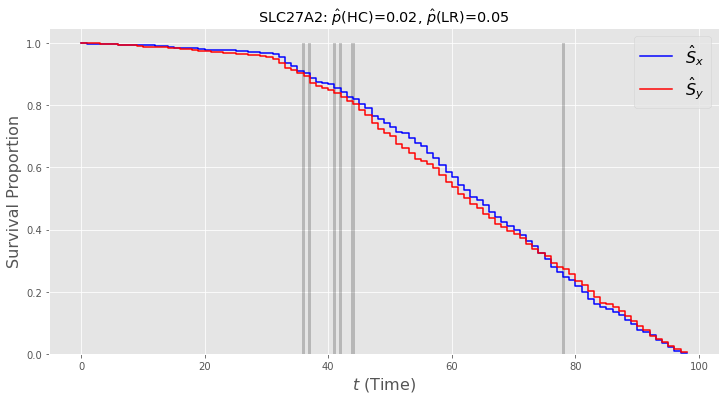

In [621]:
gene_name = 'SLC27A2'
g = illustrate_survival_curve(df, gene_name, T)
plt.savefig(remote_dir + gene_name + ".png")
plt.show()


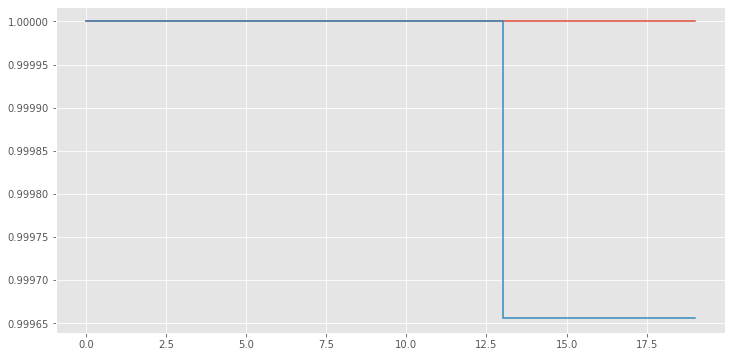

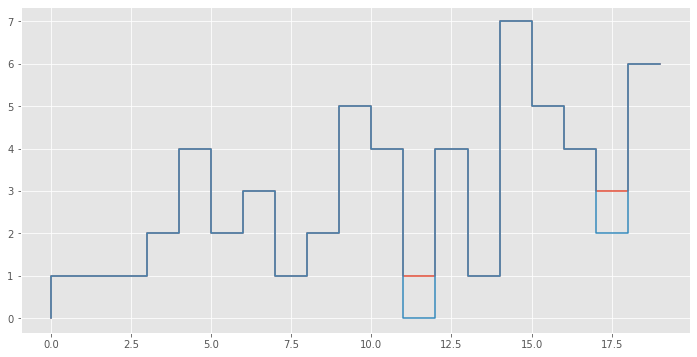

In [199]:
dfg = reduce_time_resolution(two_groups_gene(df, gene_name), 100)

Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
Ot1, Ot2 = dfg['dead1'].values[1:], dfg['dead2'].values[1:]

n = 20
plt.step(np.arange(n),Nt1[:n] / Nt1[0])
plt.step(np.arange(n),Nt2[:n] / Nt2[0])
plt.show()

plt.step(np.arange(n),Ot1[:n])
plt.step(np.arange(n),Ot2[:n])
plt.show()

,Unnamed: 0,A2M,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AARS,AASDHPPT,...,ZSCAN18,ZSCAN5A,ZW10,ZWINT,ZXDA,ZXDC,ZYX,ZZEF1,time,event


In [229]:
T = 150

df1 = two_groups_gene(df, gene_name)

Tmin = df1.index.min()
Tmax = df1.index.max()
tt = np.linspace(Tmin, Tmax, T)
dfc = pd.DataFrame()
for t_down, t_up in zip(tt[:1], tt[1:2]):
    dft = df1[(t_down <= df1.index) & (df1.index < t_up)]
    r = dft.sum()[['dead1', 'dead2']]
    r['at-risk1'] = dft['at-risk1'].max()
    r['at-risk2'] = dft['at-risk2'].max()
    dfc = dfc.append(r, ignore_index=True)
dfc.fillna(method='backfill').dropna()

KeyError: 1

In [253]:
dfg = dfg[idc_split]

dft = dfg#.groupby('time').sum()
dft = dft.sort_values('time').reset_index()
dft['total'] = len(dft)
dft['dead'] = dft.event
dft['cum_dead'] = dft.dead.cumsum()

# dft['censored'] = (~dft.event).cumsum()
# incorporate censorship. Change to 'at-risk'
dft['cum_censored'] = (dft.event == 0).cumsum()
dft['at-risk'] = dft['total']
dft.loc[1:,'at-risk'] = dft[1:]['at-risk'] - dft[:-1]['cum_dead'] - dft[:-1]['cum_censored']

<ipython-input-253-ba130468ce7c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfg = dfg[idc_split]


In [252]:
dft

,index,ADH7,time,event,total,dead,cum_dead,cum_censored,at-risk
0,2342,1,214.0,1.0,163,1.0,1.0,0,163.0
1,873,1,276.0,1.0,163,1.0,2.0,0,161.0
2,2055,1,385.0,1.0,163,1.0,3.0,0,160.0
3,846,1,546.0,1.0,163,1.0,4.0,0,159.0
4,2506,1,662.0,1.0,163,1.0,5.0,0,158.0
...,...,...,...,...,...,...,...,...,...
158,1758,1,2444.0,0.0,163,0.0,13.0,146,4.0
159,1241,1,2445.0,0.0,163,0.0,13.0,147,3.0
160,2352,1,2459.0,0.0,163,0.0,13.0,148,2.0
161,2361,1,2460.0,0.0,163,0.0,13.0,149,1.0


In [255]:
data = df.copy()
dfg = data[[gene_name, 'time', 'event']]
idc_split = dfg[gene_name] >= 1    
df1 = arrange_group(dfg[idc_split])
df2 = arrange_group(dfg[~idc_split])


In [254]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg#.groupby('time').sum()
    dft = dft.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft[1:]['at-risk'] - dft[:-1]['cum_dead'] - dft[:-1]['cum_censored']
    
    dft = dft.groupby('time').max()
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name, 'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    # Todo: merge time indices
    dfm = df1[['at-risk', 'dead']].join(df2[['at-risk', 'dead']], lsuffix='1', rsuffix='2', how='outer')\
                     .fillna(method='ffill')\
                     .fillna(method='bfill') 
    return dfm

In [237]:
dft.loc[1:, 'at-risk1']

time
56.0    162.0
Name: at-risk1, dtype: float64

In [230]:
dft = df[(t_down <= df.index) & (df.index < t_up)]
dft

KeyError: 'at-risk'

In [178]:
pvals_greater = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='greater')
pvals_greater

In [177]:
Nt2

array([2871., 2871., 2871., 2871., 2871., 2871., 2871., 2871., 2871.,
       2871., 2871., 2871., 2871., 2871., 2870., 2870., 2870., 2870.,
       2870., 2870., 2869., 2869., 2869., 2869., 2869., 2869., 2869.,
       2869., 2869., 2869., 2869., 2869., 2869., 2869., 2852., 2815.,
       2787., 2750., 2733., 2698., 2657., 2640., 2622., 2604., 2575.,
       2533., 2509., 2473., 2427., 2368., 2314., 2291., 2253., 2206.,
       2175., 2131., 2090., 2069., 2028., 1979., 1928., 1866., 1815.,
       1768., 1717., 1673., 1625., 1579., 1522., 1477., 1443., 1407.,
       1377., 1327., 1289., 1229., 1195., 1134., 1082., 1045., 1009.,
        963.,  900.,  849.,  798.,  756.,  736.,  713.,  683.,  636.,
        598.,  553.,  511.,  472.,  433.,  405.,  368.,  340.,  315.])

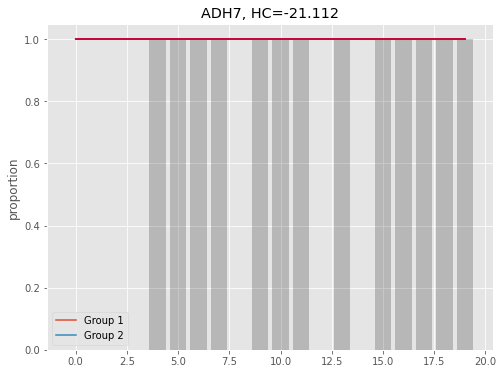

In [144]:
dfg = dfg[:20]

dfg.plot(y=['Group 1', 'Group 2'])
plt.step(dfg.index, dfg['Group 1'], 'b')
plt.step(dfg.index, dfg['Group 2'], 'r')

plt.bar(dfg.index[:len(fpval)], fpval[:len(dfg)], color='k', alpha=.2)
plt.title(f"{gene_name}, HC={np.round(r[1]['hc_greater'],3)}")
plt.ylabel('proportion')
#plt.savefig(f"Figs/{gene_name}.png")
#plt.xlim(1000, 1500)
plt.show()


In [156]:
multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)


def multi_pvals(Nt1, Nt2, Ot1, Ot2, test='hypergeom',
                randomize=False, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """

assert (len(Nt1) == len(Nt2))
assert (len(Ot1)+1 == len(Nt1))
assert (len(Ot2)+1 == len(Nt2))

Nt = Nt2 + Nt1


n = Ot1 + Ot2
p = Nt2[:-1] / Nt[:-1]
x = Ot2
pvals_binom = binom_test(x, n, p, alt='greater')

pvals = hypergeom_test(Ot2, Nt[:-1], Nt2[:-1], Ot1 + Ot2,
                        randomize=False, alternative='greater')


In [170]:
for i in range(10):
    print(Ot2[i], Nt[i], Nt2[i], Ot1[i] + Ot2[i], pvals[i])

0.0 3067.0 162.0 0.0 1.0
1.0 3067.0 162.0 2.0 0.10286702011246543
1.0 3067.0 162.0 2.0 0.10286702011246543
1.0 3067.0 162.0 2.0 0.10286702011246543
2.0 3067.0 162.0 4.0 0.015506232012022954
4.0 3067.0 162.0 8.0 0.0004445436445584255
2.0 3067.0 162.0 4.0 0.015506232012022954
3.0 3067.0 162.0 6.0 0.0025714778357432896
1.0 3067.0 162.0 2.0 0.10286702011246543
2.0 3067.0 162.0 4.0 0.015506232012022954


3067.0

In [164]:
Nt2[i]

162.0

In [165]:
Nt1[i]

2905.0

In [166]:
Ot1[i] + Ot2[i]

0.0

In [160]:
pvals

array([1.00000000e+00, 1.02867020e-01, 1.02867020e-01, 1.02867020e-01,
       1.55062320e-02, 4.44543645e-04, 1.55062320e-02, 2.57147784e-03,
       1.02867020e-01, 1.55062320e-02, 7.85481628e-05, 4.44543645e-04,
       5.28203456e-02, 4.44543645e-04, 1.02899666e-01, 2.53739399e-06,
       7.86707141e-05, 4.45099271e-04, 1.33881421e-03, 1.40784288e-05,
       7.87934947e-05, 7.87934947e-05, 2.57631326e-03, 2.57631326e-03,
       1.55257506e-02, 2.57631326e-03, 4.45655766e-04, 2.57631326e-03,
       7.87934947e-05, 1.41047739e-05, 4.45655766e-04, 1.41047739e-05,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 2.17780828e-08, 4.41225293e-04, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.51713358e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.07830162e-08, 1.00000000e+00, 5.82685457e-10, 9.64475040e-09,
      

In [ ]:
pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
hc, hct = mt.hc(gamma=.5)



In [131]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=False, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct

fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)

pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
mt = MultiTest(pvals[pvals<=1], stbl=stbl) # if not using stbl=False, then sometimes
hc, hct = mt.hc(gamma=.5)


(pvals <= hct) == fpval

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [104]:
len(pvals)

98

## Atomic experiment:

In [125]:
T = 100
N1 = 1000
N2 = 1000
eps = 0.01
mu = 0.05
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2)

{'Logrank': 0.036565641369759184,
 'HC': 19.898989898874632,
 'Fisher': 3.02571473857662,
 'minP': 31.3855699267849,
 'BJ': 46.04514669138503}

In [126]:
log_rank_test(Nt1, Nt2)

(0.036565641369759184, 0.848352102234302)

In [130]:
_log_rank_test(Nt1, Nt2, alternative='two-sided')

(2.2805518191857352, 0.02257498112069625)

In [132]:
dfg

,at-risk1,at-risk2,Group 1,Group 2
time,,,,
56.0,1533.0,1534.0,1.000000,1.000000
93.0,1533.0,1533.0,1.000000,0.999348
101.0,1533.0,1532.0,1.000000,0.998696
136.0,1533.0,1532.0,1.000000,0.998696
141.0,1533.0,1531.0,1.000000,0.998044
...,...,...,...,...
2469.0,1373.0,1374.0,0.895629,0.895698
2472.0,1373.0,1374.0,0.895629,0.895698
2473.0,1373.0,1374.0,0.895629,0.895698


In [59]:
df.time.min()

56.0